## Imports

In [1]:
import pandas as pd
import numpy as np

import cv2

import os
import shutil
import pickle
import pywt

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# remove warning for clean notebook
import warnings
warnings.filterwarnings("ignore")

## Functions

In [2]:
# get gray image given path
def get_gray_img(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)

In [3]:
def get_face_roi(img_path):
    
    img = cv2.imread(img_path)
   
    if img is not None:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        faces = face_cascade.detectMultiScale(img, 1.3, 5)

        for (x, y, width, height) in faces:

            roi_gray = gray[y : y + height, x : x + width]
            roi_color = img[y : y + height, x : x + width]

            # get eyes roi
            eyes = eye_cascade.detectMultiScale(roi_gray)

            # only return if there are 2 eyes detect on the image
            if len(eyes) >= 2:
                return roi_color

In [4]:
def w2d(img, mode='haar', level=1):
    imArray = img
    
    # Datatype conversions
    # convert to grayscale
    imArray = cv2.cvtColor(imArray ,cv2.COLOR_RGB2GRAY)
    
    # convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    
    # compute coefficients 
    coeffs = pywt.wavedec2(imArray, mode, level = level)

    #Process Coefficients
    coeffs_H = list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H = pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [5]:
def transform_imgs(path_to_roi_data, img_directories):
    
    roi_img_directories = []

    # iterate image directories
    for img_dir in img_directories:
        
        count = 1

        # get filename from images directories
        filename = img_dir.split('/')[-1]

        for entry in os.scandir(img_dir):

            # get roi image
            roi_img = get_face_roi(entry.path) 
            
            if roi_img is not None:
                roi_folder = path_to_roi_data + filename

                # if folder doesn't exist
                if not os.path.exists(roi_folder):
                    os.makedirs(roi_folder)
                    roi_img_directories.append(roi_folder)
                    
                    print('Generating roi images in folder:', roi_folder)
                
                if count < 10:
                    roi_file_name = filename + '_0' + str(count) + '.png'
                else:
                    roi_file_name = filename + '_' + str(count) + '.png'
                     
                roi_file_path = roi_folder + '/' + roi_file_name

                cv2.imwrite(roi_file_path, roi_img)
                count += 1
                
    return roi_img_directories

In [6]:
def get_img_directories(path):
    
    img_directories = []
    
    for entry in os.scandir(path_to_data):
        if entry.is_dir():
            img_directories.append(entry.path)

    return img_directories

In [7]:
def get_roi_img_directories(roi_img_directories):
    
    filenames_dict = {}
    
    for img_directory in roi_img_directories:
        
        filename = img_directory.split('/')[-1]
        file_list = []
        
        for entry in os.scandir(img_directory):
            file_list.append(entry.path)
        filenames_dict[filename] = file_list
    
    return filenames_dict

In [8]:
def check_create_directory(path):

    # if directory already exist, delete
    if os.path.exists(path_to_roi_data):
        shutil.rmtree(path_to_roi_data)

    # create new folder to store roi from dataset
    os.mkdir(path_to_roi_data)

In [9]:
def get_class_dictionary(filename_dictionary):
    class_dictionary = {}
    count = 0

    for filename in filename_dictionary.keys():
        class_dictionary[filename] = count
        count += 1

    return class_dictionary

In [10]:
def get_X_y(filename_dictionary, class_dictionary):
    
    X = []
    y = []

    for filename, training_files in filename_dictionary.items():
        for training_image in training_files:
            img_raw = cv2.imread(training_image)

            if img_raw is None:
                continue

            img_har = w2d(img_raw, 'db1', 5)

            scaled_raw_img = cv2.resize(img_raw, (32, 32))
            scaled_har_img = cv2.resize(img_har, (32, 32))

            img_combined = np.vstack((scaled_raw_img.reshape(32 * 32 * 3, 1), scaled_har_img.reshape(32 * 32, 1)))

            X.append(img_combined)
            y.append(class_dictionary[filename])
            
    return X, y

In [11]:
# save X and y for modelling purpose
def save_X_y(X, y):
    
    with open('pickle/data_X.pickle', 'wb') as f:
        pickle.dump(X, f)
        
    with open('pickle/data_y.pickle', 'wb') as f:
        pickle.dump(y, f)

## Data Management

### Data Exploration

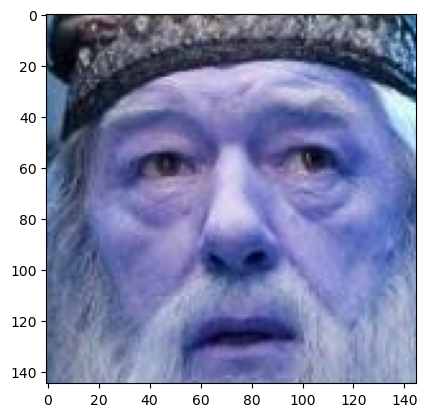

In [12]:
# initialized face and eyes cascade
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

# get roi for test image
path_test_img = './test_images/albus_dumbeldore_01.jpeg'
roi_color = get_face_roi(path_test_img)

plt.imshow(roi_color, cmap = 'gray')

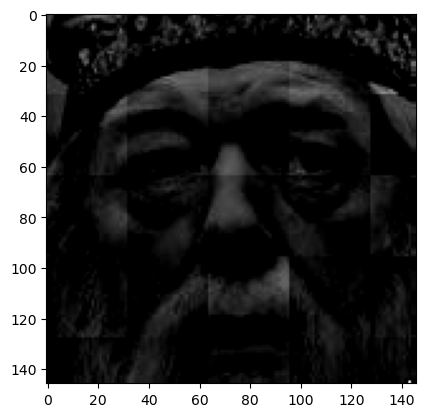

In [13]:
# get haar image for data processing later
roi_har = w2d(roi_color, 'db1', 5)
plt.imshow(roi_har, cmap = 'gray')

### Data transformation

#### Get directories

In [14]:
# prepare paths for data transformation
path_to_data = './dataset/'
path_to_roi_data = './dataset/00_roi_imgs/'

# store images directory into an array
img_directories = get_img_directories(path_to_data)

# initialize roi directory
check_create_directory(path_to_roi_data)

# transform all images into roi images
roi_img_directories = transform_imgs(path_to_roi_data, img_directories)

# record roi images into dictionary after manually clean the data
filename_dictionary = get_roi_img_directories(roi_img_directories)

# get class based on filename
class_dictionary = get_class_dictionary(filename_dictionary)

Generating roi images in folder: ./dataset/00_roi_imgs/albus_dumbeldore
Generating roi images in folder: ./dataset/00_roi_imgs/hermione_granger
Generating roi images in folder: ./dataset/00_roi_imgs/harry_potter
Generating roi images in folder: ./dataset/00_roi_imgs/ron_weasley
Generating roi images in folder: ./dataset/00_roi_imgs/rubeus_hagrid


#### Prepare X and y

In [15]:
# get X and y
X, y = get_X_y(filename_dictionary, class_dictionary)

# reshape X
X = np.array(X).reshape(len(X), 4096).astype(float)

# store X and y into pickle file
save_X_y(X, y)